# 1. Library Import

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Flatten#,GRU
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings("ignore")

# 2. 데이터 가공

## 2.1 read_csv

In [2]:
data_path = './data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2.2 numpy array로 변환

In [3]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [4]:
train_x_array = df2d_to_array3d(train_x_df)   #(7362, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(7362, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

# 3. 모델 훈련하기

## 3.1 훈련 층 쌓기(모델 구성)

In [5]:
model=Sequential([
LSTM(units = 32, input_shape=[1380, 1], activation = 'relu'),
Dense(120 * 1),
Reshape([120, 1])
])

In [6]:
# model = Sequential()
# model.add(LSTM(7, input_shape = (1380,1), activation = 'relu'))  #
# model.add(Dense(4))
# # model.add(Flatten())
# model.add(Dense(1))

In [7]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [8]:
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001762ABFDAC8>>

# 결과 불만족 스러우면 optimizer 바꿔보고 sample_id도 증가시키고 LSTM층도 더 쌓아서 학습 파라미터 수 늘리기

## 3.2 validation set 훈련하기 

### 3.2.1 validation 데이터 생성하기

In [9]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 100]
valid_y_df = train_y_df[train_y_df.sample_id < 100]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([100, 120, 1])

### 3.2.2 학습 및 예측하기(compile구성 및 fit 포함)

In [10]:
for idx in tqdm(range(valid_x_array.shape[0])):
    #학습
    x_series = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
    y_series = np.reshape(valid_y_array[idx,:,1], (1, 120, 1))
    model.fit(x_series, y_series, epochs = 10, batch_size = 32)

  0%|          | 0/100 [00:00<?, ?it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 6s 6s/sample - loss: 1.0368 - mse: 1.0368
Epoch 2/10
1/1 [==============================] - 0s 66ms/sample - loss: 1.0244 - mse: 1.0244
Epoch 3/10
1/1 [==============================] - 0s 54ms/sample - loss: 1.0128 - mse: 1.0128
Epoch 4/10
1/1 [==============================] - 0s 37ms/sample - loss: 1.0018 - mse: 1.0018
Epoch 5/10
1/1 [==============================] - 0s 39ms/sample - loss: 0.9914 - mse: 0.9914
Epoch 6/10
1/1 [==============================] - 0s 51ms/sample - loss: 0.9813 - mse: 0.9813
Epoch 7/10
1/1 [==============================] - 0s 82ms/sample - loss: 0.9716 - mse: 0.9716
Epoch 8/10
1/1 [==============================] - 0s 50ms/sample - loss: 0.9621 - mse: 0.9621
Epoch 9/10
1/1 [==============================] - 0s 36ms/sample - loss: 0.9527 - mse: 0.9527
Epoch 10/10
1/1 [==============================] - 0s 60ms/sample - loss: 0.9433 - mse: 0.9433


  1%|          | 1/100 [00:06<10:06,  6.13s/it]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 38ms/sample - loss: 0.9523 - mse: 0.9523
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.9426 - mse: 0.9426
Epoch 3/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.9327 - mse: 0.9327
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.9224 - mse: 0.9224
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.9117 - mse: 0.9117
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.9003 - mse: 0.9003
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.8882 - mse: 0.8882
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.8752 - mse: 0.8752
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.8611 - mse: 0.8611
Epoch 10/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.8457 - mse: 0.8457


  2%|▏         | 2/100 [00:06<04:31,  2.77s/it]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.8200 - mse: 0.8200
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.8015 - mse: 0.8015
Epoch 3/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.7809 - mse: 0.7809
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.7579 - mse: 0.7579
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.7322 - mse: 0.7322
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.7036 - mse: 0.7036
Epoch 7/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.6718 - mse: 0.6718
Epoch 8/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.6370 - mse: 0.6370
Epoch 9/10
1/1 [==============================] - 0s 39ms/sample - loss: 0.5994 - mse: 0.5994
Epoch 10/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.5598 - mse: 0.5598


  3%|▎         | 3/100 [00:06<02:42,  1.67s/it]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 0.5166 - mse: 0.5166
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.4763 - mse: 0.4763
Epoch 3/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.4371 - mse: 0.4371
Epoch 4/10
1/1 [==============================] - 0s 37ms/sample - loss: 0.3999 - mse: 0.3999
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.3650 - mse: 0.3650
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.3324 - mse: 0.3324
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.3021 - mse: 0.3021
Epoch 8/10
1/1 [==============================] - 0s 41ms/sample - loss: 0.2739 - mse: 0.2739
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.2478 - mse: 0.2478
Epoch 10/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.2238 - mse: 0.2238


  4%|▍         | 4/100 [00:07<01:52,  1.17s/it]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.2019 - mse: 0.2019
Epoch 2/10
1/1 [==============================] - 0s 44ms/sample - loss: 0.1819 - mse: 0.1819
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.1637 - mse: 0.1637
Epoch 4/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.1473 - mse: 0.1473
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.1325 - mse: 0.1325
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.1193 - mse: 0.1193
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.1073 - mse: 0.1073
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0965 - mse: 0.0965
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0867 - mse: 0.0867
Epoch 10/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0777 - mse: 0.0777


  5%|▌         | 5/100 [00:07<01:28,  1.08it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0721 - mse: 0.0721
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0638 - mse: 0.0638
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0561 - mse: 0.0561
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0490 - mse: 0.0490
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 0.0426 - mse: 0.0426
Epoch 6/10
1/1 [==============================] - 0s 37ms/sample - loss: 0.0367 - mse: 0.0367
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0315 - mse: 0.0315
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0268 - mse: 0.0268
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 0.0226 - mse: 0.0226
Epoch 10/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0190 - mse: 0.0190


  6%|▌         | 6/100 [00:08<01:08,  1.37it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 0.0166 - mse: 0.0166
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 0.0139 - mse: 0.0139
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0116 - mse: 0.0116
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0096 - mse: 0.0096
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0080 - mse: 0.0080
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0068 - mse: 0.0068
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0058 - mse: 0.0058
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0050 - mse: 0.0050
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0045 - mse: 0.0045
Epoch 10/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0041 - mse: 0.0041


  7%|▋         | 7/100 [00:08<00:56,  1.64it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 0.0038 - mse: 0.0038
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0036 - mse: 0.0036
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0034 - mse: 0.0034
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0033 - mse: 0.0033
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0031 - mse: 0.0031
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0030 - mse: 0.0030
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0028 - mse: 0.0028
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0027 - mse: 0.0027
Epoch 9/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.0025 - mse: 0.0025
Epoch 10/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.0023 - mse: 0.0023


  8%|▊         | 8/100 [00:08<00:48,  1.88it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.0020 - mse: 0.0020
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 0.0018 - mse: 0.0018
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0017 - mse: 0.0017
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0015 - mse: 0.0015
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0013 - mse: 0.0013
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0012 - mse: 0.0012
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0011 - mse: 0.0011
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.4774e-04 - mse: 9.4774e-04
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 8.4206e-04 - mse: 8.4206e-04
Epoch 10/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.4730e-04 - mse: 7.4730e-04


  9%|▉         | 9/100 [00:09<00:43,  2.11it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 8.5981e-04 - mse: 8.5981e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.8164e-04 - mse: 7.8164e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.0928e-04 - mse: 7.0928e-04
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 6.4240e-04 - mse: 6.4240e-04
Epoch 5/10
1/1 [==============================] - 0s 35ms/sample - loss: 5.8067e-04 - mse: 5.8067e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.2378e-04 - mse: 5.2378e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.7144e-04 - mse: 4.7144e-04
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.2342e-04 - mse: 4.2342e-04
Epoch 9/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.7948e-04 - mse: 3.7948e-04
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 10%|█         | 10/100 [00:09<00:39,  2.28it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 3.8227e-04 - mse: 3.8227e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.5986e-04 - mse: 3.5986e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.3064e-04 - mse: 3.3064e-04
Epoch 4/10
1/1 [==============================] - 0s 37ms/sample - loss: 2.9692e-04 - mse: 2.9692e-04
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.6142e-04 - mse: 2.6142e-04
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.2682e-04 - mse: 2.2682e-04
Epoch 7/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.9532e-04 - mse: 1.9532e-04
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.6839e-04 - mse: 1.6839e-04
Epoch 9/10
1/1 [==============================] - 0s 36ms/sample - loss: 1.4676e-04 - mse: 1.4676e-04
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 11%|█         | 11/100 [00:09<00:37,  2.37it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.9606e-04 - mse: 1.9606e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.0411e-04 - mse: 2.0411e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0585e-04 - mse: 2.0585e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.0029e-04 - mse: 2.0029e-04
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.8768e-04 - mse: 1.8768e-04
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.6928e-04 - mse: 1.6928e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4697e-04 - mse: 1.4697e-04
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.2292e-04 - mse: 1.2292e-04
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.9275e-05 - mse: 9.9275e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 12%|█▏        | 12/100 [00:10<00:35,  2.49it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.7282e-04 - mse: 1.7282e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.4128e-04 - mse: 1.4128e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1237e-04 - mse: 1.1237e-04
Epoch 4/10
1/1 [==============================] - 0s 27ms/sample - loss: 8.8133e-05 - mse: 8.8133e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.9684e-05 - mse: 6.9684e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.7195e-05 - mse: 5.7195e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.0052e-05 - mse: 5.0052e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.7083e-05 - mse: 4.7083e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.6832e-05 - mse: 4.6832e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 13%|█▎        | 13/100 [00:10<00:33,  2.60it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 2.5603e-04 - mse: 2.5603e-04
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.5849e-04 - mse: 2.5849e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.4313e-04 - mse: 2.4313e-04
Epoch 4/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.1400e-04 - mse: 2.1400e-04
Epoch 5/10
1/1 [==============================] - 0s 36ms/sample - loss: 1.7655e-04 - mse: 1.7655e-04
Epoch 6/10
1/1 [==============================] - 0s 73ms/sample - loss: 1.3647e-04 - mse: 1.3647e-04
Epoch 7/10
1/1 [==============================] - 0s 39ms/sample - loss: 9.8814e-05 - mse: 9.8814e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.7317e-05 - mse: 6.7317e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.4117e-05 - mse: 4.4117e-05
Epoch 10/10
1/1 [==============================] - 0s 34ms/samp

 14%|█▍        | 14/100 [00:11<00:34,  2.52it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.0190e-04 - mse: 1.0190e-04
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0520e-04 - mse: 1.0520e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0961e-04 - mse: 1.0961e-04
Epoch 4/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.1294e-04 - mse: 1.1294e-04
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.1352e-04 - mse: 1.1352e-04
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.1044e-04 - mse: 1.1044e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0348e-04 - mse: 1.0348e-04
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.3110e-05 - mse: 9.3110e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 8.0272e-05 - mse: 8.0272e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 15%|█▌        | 15/100 [00:11<00:33,  2.56it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 38ms/sample - loss: 8.4677e-04 - mse: 8.4677e-04
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 8.3842e-04 - mse: 8.3842e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 7.8918e-04 - mse: 7.8918e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.0866e-04 - mse: 7.0866e-04
Epoch 5/10
1/1 [==============================] - 0s 34ms/sample - loss: 6.0890e-04 - mse: 6.0890e-04
Epoch 6/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.0227e-04 - mse: 5.0227e-04
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.9959e-04 - mse: 3.9959e-04
Epoch 8/10
1/1 [==============================] - 0s 35ms/sample - loss: 3.0902e-04 - mse: 3.0902e-04
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3548e-04 - mse: 2.3548e-04
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 16%|█▌        | 16/100 [00:11<00:32,  2.57it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.6250e-04 - mse: 9.6250e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0010 - mse: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 0.0010 - mse: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 9.8064e-04 - mse: 9.8064e-04
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 8.5962e-04 - mse: 8.5962e-04
Epoch 6/10
1/1 [==============================] - 0s 27ms/sample - loss: 7.0680e-04 - mse: 7.0680e-04
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 5.4489e-04 - mse: 5.4489e-04
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.9401e-04 - mse: 3.9401e-04
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.6929e-04 - mse: 2.6929e-04
Epoch 10/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.794

 17%|█▋        | 17/100 [00:12<00:31,  2.66it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 9.8884e-05 - mse: 9.8884e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.5106e-05 - mse: 9.5106e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1322e-04 - mse: 1.1322e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.4184e-04 - mse: 1.4184e-04
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.7045e-04 - mse: 1.7045e-04
Epoch 6/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.9095e-04 - mse: 1.9095e-04
Epoch 7/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.9862e-04 - mse: 1.9862e-04
Epoch 8/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.9225e-04 - mse: 1.9225e-04
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7358e-04 - mse: 1.7358e-04
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 18%|█▊        | 18/100 [00:12<00:30,  2.68it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.4587e-05 - mse: 4.4587e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.5507e-05 - mse: 3.5507e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.1208e-05 - mse: 3.1208e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.0439e-05 - mse: 3.0439e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.1679e-05 - mse: 3.1679e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.3456e-05 - mse: 3.3456e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.4599e-05 - mse: 3.4599e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.4369e-05 - mse: 3.4369e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.2502e-05 - mse: 3.2502e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 19%|█▉        | 19/100 [00:12<00:29,  2.74it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 5.2146e-05 - mse: 5.2146e-05
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.2123e-05 - mse: 5.2123e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.9961e-05 - mse: 4.9961e-05
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.6028e-05 - mse: 4.6028e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.0866e-05 - mse: 4.0866e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.5091e-05 - mse: 3.5091e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.9296e-05 - mse: 2.9296e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.3970e-05 - mse: 2.3970e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.9449e-05 - mse: 1.9449e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 20%|██        | 20/100 [00:13<00:28,  2.76it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.9886e-05 - mse: 2.9886e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.0671e-05 - mse: 3.0671e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.0284e-05 - mse: 3.0284e-05
Epoch 4/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.8611e-05 - mse: 2.8611e-05
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.5796e-05 - mse: 2.5796e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2174e-05 - mse: 2.2174e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.8177e-05 - mse: 1.8177e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4247e-05 - mse: 1.4247e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0758e-05 - mse: 1.0758e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 21%|██        | 21/100 [00:13<00:28,  2.77it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 4.7748e-05 - mse: 4.7748e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 5.1018e-05 - mse: 5.1018e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.1525e-05 - mse: 5.1525e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.9382e-05 - mse: 4.9382e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.5081e-05 - mse: 4.5081e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.9344e-05 - mse: 3.9344e-05
Epoch 7/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.2966e-05 - mse: 3.2966e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.6677e-05 - mse: 2.6677e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.1036e-05 - mse: 2.1036e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 22%|██▏       | 22/100 [00:13<00:28,  2.77it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.2391e-05 - mse: 3.2391e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.4306e-05 - mse: 3.4306e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.4362e-05 - mse: 3.4362e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.2498e-05 - mse: 3.2498e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.9030e-05 - mse: 2.9030e-05
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.4527e-05 - mse: 2.4527e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.9657e-05 - mse: 1.9657e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.5055e-05 - mse: 1.5055e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1206e-05 - mse: 1.1206e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 23%|██▎       | 23/100 [00:14<00:27,  2.79it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.8844e-04 - mse: 2.8844e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.5061e-04 - mse: 2.5061e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0204e-04 - mse: 2.0204e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.5119e-04 - mse: 1.5119e-04
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0537e-04 - mse: 1.0537e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.9674e-05 - mse: 6.9674e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.6431e-05 - mse: 4.6431e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.5312e-05 - mse: 3.5312e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.3903e-05 - mse: 3.3903e-05
Epoch 10/10
1/1 [==============================] - 0s 33ms/samp

 24%|██▍       | 24/100 [00:14<00:27,  2.78it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 3.3456e-04 - mse: 3.3456e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.4722e-04 - mse: 3.4722e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.2558e-04 - mse: 3.2558e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.7800e-04 - mse: 2.7800e-04
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.1655e-04 - mse: 2.1655e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.5373e-04 - mse: 1.5373e-04
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 9.9800e-05 - mse: 9.9800e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.1141e-05 - mse: 6.1141e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.9823e-05 - mse: 3.9823e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 25%|██▌       | 25/100 [00:15<00:26,  2.78it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 8.9462e-05 - mse: 8.9462e-05
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0422e-04 - mse: 1.0422e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1614e-04 - mse: 1.1614e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.2142e-04 - mse: 1.2142e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1840e-04 - mse: 1.1840e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0746e-04 - mse: 1.0746e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.0596e-05 - mse: 9.0596e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.0721e-05 - mse: 7.0721e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.0925e-05 - mse: 5.0925e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 26%|██▌       | 26/100 [00:15<00:26,  2.80it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 9.1675e-05 - mse: 9.1675e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0943e-04 - mse: 1.0943e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1909e-04 - mse: 1.1909e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.1931e-04 - mse: 1.1931e-04
Epoch 5/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.1079e-04 - mse: 1.1079e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.5779e-05 - mse: 9.5779e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.7337e-05 - mse: 7.7337e-05
Epoch 8/10
1/1 [==============================] - 0s 27ms/sample - loss: 5.8579e-05 - mse: 5.8579e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.2066e-05 - mse: 4.2066e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 27%|██▋       | 27/100 [00:15<00:25,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.0109e-04 - mse: 5.0109e-04
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 5.1201e-04 - mse: 5.1201e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.7798e-04 - mse: 4.7798e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.0958e-04 - mse: 4.0958e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.2201e-04 - mse: 3.2201e-04
Epoch 6/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.3143e-04 - mse: 2.3143e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.5179e-04 - mse: 1.5179e-04
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 9.2563e-05 - mse: 9.2563e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.7674e-05 - mse: 5.7674e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 28%|██▊       | 28/100 [00:16<00:25,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.9370e-04 - mse: 3.9370e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.5746e-04 - mse: 4.5746e-04
Epoch 3/10
1/1 [==============================] - 0s 27ms/sample - loss: 4.6952e-04 - mse: 4.6952e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.3315e-04 - mse: 4.3315e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.6160e-04 - mse: 3.6160e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.7312e-04 - mse: 2.7312e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.8588e-04 - mse: 1.8588e-04
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1408e-04 - mse: 1.1408e-04
Epoch 9/10
1/1 [==============================] - 0s 34ms/sample - loss: 6.5758e-05 - mse: 6.5758e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 29%|██▉       | 29/100 [00:16<00:25,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 9.3828e-05 - mse: 9.3828e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3505e-04 - mse: 1.3505e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.6691e-04 - mse: 1.6691e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8228e-04 - mse: 1.8228e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.7906e-04 - mse: 1.7906e-04
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.5957e-04 - mse: 1.5957e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.2915e-04 - mse: 1.2915e-04
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.4506e-05 - mse: 9.4506e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.2059e-05 - mse: 6.2059e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 30%|███       | 30/100 [00:16<00:24,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.6063e-05 - mse: 5.6063e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 7.6001e-05 - mse: 7.6001e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 9.2925e-05 - mse: 9.2925e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0255e-04 - mse: 1.0255e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0290e-04 - mse: 1.0290e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.4352e-05 - mse: 9.4352e-05
Epoch 7/10
1/1 [==============================] - 0s 34ms/sample - loss: 7.9133e-05 - mse: 7.9133e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.0526e-05 - mse: 6.0526e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.1961e-05 - mse: 4.1961e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 31%|███       | 31/100 [00:17<00:24,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 49ms/sample - loss: 1.2106e-05 - mse: 1.2106e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.5965e-06 - mse: 7.5965e-06
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.4333e-06 - mse: 7.4333e-06
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0242e-05 - mse: 1.0242e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4362e-05 - mse: 1.4362e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8248e-05 - mse: 1.8248e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0769e-05 - mse: 2.0769e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.1359e-05 - mse: 2.1359e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.0015e-05 - mse: 2.0015e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 32%|███▏      | 32/100 [00:17<00:26,  2.53it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 9.4212e-05 - mse: 9.4212e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 8.0071e-05 - mse: 8.0071e-05
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.2789e-05 - mse: 6.2789e-05
Epoch 4/10
1/1 [==============================] - 0s 35ms/sample - loss: 4.5678e-05 - mse: 4.5678e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.1345e-05 - mse: 3.1345e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.1298e-05 - mse: 2.1298e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.5860e-05 - mse: 1.5860e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.4356e-05 - mse: 1.4356e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.5467e-05 - mse: 1.5467e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 33%|███▎      | 33/100 [00:18<00:25,  2.59it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7288e-04 - mse: 1.7288e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7077e-04 - mse: 1.7077e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.5204e-04 - mse: 1.5204e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2266e-04 - mse: 1.2266e-04
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 8.9714e-05 - mse: 8.9714e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.9629e-05 - mse: 5.9629e-05
Epoch 7/10
1/1 [==============================] - 0s 34ms/sample - loss: 3.6866e-05 - mse: 3.6866e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.3370e-05 - mse: 2.3370e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8705e-05 - mse: 1.8705e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 34%|███▍      | 34/100 [00:18<00:24,  2.66it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 30ms/sample - loss: 8.8034e-05 - mse: 8.8034e-05
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0163e-04 - mse: 1.0163e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0354e-04 - mse: 1.0354e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 9.4534e-05 - mse: 9.4534e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.7715e-05 - mse: 7.7715e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.7390e-05 - mse: 5.7390e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.7866e-05 - mse: 3.7866e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2479e-05 - mse: 2.2479e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3027e-05 - mse: 1.3027e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 35%|███▌      | 35/100 [00:18<00:23,  2.72it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.2528e-04 - mse: 1.2528e-04
Epoch 2/10
1/1 [==============================] - 0s 37ms/sample - loss: 9.5940e-05 - mse: 9.5940e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.9879e-05 - mse: 6.9879e-05
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.0217e-05 - mse: 5.0217e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.8038e-05 - mse: 3.8038e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.2622e-05 - mse: 3.2622e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.2016e-05 - mse: 3.2016e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.3772e-05 - mse: 3.3772e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.5625e-05 - mse: 3.5625e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 36%|███▌      | 36/100 [00:19<00:23,  2.72it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.2307e-04 - mse: 3.2307e-04
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.9659e-04 - mse: 2.9659e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.4558e-04 - mse: 2.4558e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8408e-04 - mse: 1.8408e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2558e-04 - mse: 1.2558e-04
Epoch 6/10
1/1 [==============================] - 0s 34ms/sample - loss: 7.9935e-05 - mse: 7.9935e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.1914e-05 - mse: 5.1914e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 4.1288e-05 - mse: 4.1288e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.4045e-05 - mse: 4.4045e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 37%|███▋      | 37/100 [00:19<00:22,  2.74it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.6773e-04 - mse: 7.6773e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.5995e-04 - mse: 7.5995e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.7477e-04 - mse: 6.7477e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.3847e-04 - mse: 5.3847e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.8391e-04 - mse: 3.8391e-04
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.4217e-04 - mse: 2.4217e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3599e-04 - mse: 1.3599e-04
Epoch 8/10
1/1 [==============================] - 0s 35ms/sample - loss: 7.6125e-05 - mse: 7.6125e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.0936e-05 - mse: 6.0936e-05
Epoch 10/10
1/1 [==============================] - 0s 27ms/samp

 38%|███▊      | 38/100 [00:19<00:22,  2.75it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 7.2501e-04 - mse: 7.2501e-04
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 7.9385e-04 - mse: 7.9385e-04
Epoch 3/10
1/1 [==============================] - 0s 26ms/sample - loss: 7.6027e-04 - mse: 7.6027e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.4503e-04 - mse: 6.4503e-04
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.8548e-04 - mse: 4.8548e-04
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.2228e-04 - mse: 3.2228e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8831e-04 - mse: 1.8831e-04
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0228e-04 - mse: 1.0228e-04
Epoch 9/10
1/1 [==============================] - 0s 33ms/sample - loss: 6.7479e-05 - mse: 6.7479e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 39%|███▉      | 39/100 [00:20<00:21,  2.77it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2641e-04 - mse: 1.2641e-04
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.6189e-04 - mse: 1.6189e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.8948e-04 - mse: 1.8948e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.0003e-04 - mse: 2.0003e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.9082e-04 - mse: 1.9082e-04
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.6486e-04 - mse: 1.6486e-04
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.2890e-04 - mse: 1.2890e-04
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.1109e-05 - mse: 9.1109e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.8786e-05 - mse: 5.8786e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 40%|████      | 40/100 [00:20<00:21,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 8.4192e-05 - mse: 8.4192e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 5.7114e-05 - mse: 5.7114e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.1473e-05 - mse: 4.1473e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.6630e-05 - mse: 3.6630e-05
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.9577e-05 - mse: 3.9577e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.6166e-05 - mse: 4.6166e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.2379e-05 - mse: 5.2379e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.5315e-05 - mse: 5.5315e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.3700e-05 - mse: 5.3700e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 41%|████      | 41/100 [00:20<00:20,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.0365e-04 - mse: 1.0365e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 8.4209e-05 - mse: 8.4209e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 6.2229e-05 - mse: 6.2229e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.2544e-05 - mse: 4.2544e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.8398e-05 - mse: 2.8398e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0990e-05 - mse: 2.0990e-05
Epoch 7/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.9626e-05 - mse: 1.9626e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2317e-05 - mse: 2.2317e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.6573e-05 - mse: 2.6573e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 42%|████▏     | 42/100 [00:21<00:20,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.8760e-05 - mse: 6.8760e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.4913e-05 - mse: 6.4913e-05
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.5423e-05 - mse: 5.5423e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.2760e-05 - mse: 4.2760e-05
Epoch 5/10
1/1 [==============================] - 0s 26ms/sample - loss: 2.9747e-05 - mse: 2.9747e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.8806e-05 - mse: 1.8806e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.1445e-05 - mse: 1.1445e-05
Epoch 8/10
1/1 [==============================] - 0s 37ms/sample - loss: 8.0611e-06 - mse: 8.0611e-06
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 8.0602e-06 - mse: 8.0602e-06
Epoch 10/10
1/1 [==============================] - 0s 36ms/samp

 43%|████▎     | 43/100 [00:21<00:20,  2.79it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.2290e-05 - mse: 4.2290e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.6807e-05 - mse: 4.6807e-05
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.6030e-05 - mse: 4.6030e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.0735e-05 - mse: 4.0735e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.2649e-05 - mse: 3.2649e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.3822e-05 - mse: 2.3822e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.6045e-05 - mse: 1.6045e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0470e-05 - mse: 1.0470e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.4653e-06 - mse: 7.4653e-06
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 44%|████▍     | 44/100 [00:21<00:19,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.0463e-05 - mse: 1.0463e-05
Epoch 2/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.1278e-05 - mse: 1.1278e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.1942e-05 - mse: 1.1942e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1951e-05 - mse: 1.1951e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.1122e-05 - mse: 1.1122e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.5737e-06 - mse: 9.5737e-06
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.6278e-06 - mse: 7.6278e-06
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 5.6804e-06 - mse: 5.6804e-06
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.0790e-06 - mse: 4.0790e-06
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 45%|████▌     | 45/100 [00:22<00:19,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 0.0012 - mse: 0.0012
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0011 - mse: 0.0011
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.2856e-04 - mse: 9.2856e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.2606e-04 - mse: 7.2606e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.2221e-04 - mse: 5.2221e-04
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.4940e-04 - mse: 3.4940e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.2610e-04 - mse: 2.2610e-04
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.5606e-04 - mse: 1.5606e-04
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3131e-04 - mse: 1.3131e-04
Epoch 10/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.369

 46%|████▌     | 46/100 [00:22<00:19,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.0017 - mse: 0.0017
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 0.0018 - mse: 0.0018
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0016 - mse: 0.0016
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0014 - mse: 0.0014
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0010 - mse: 0.0010
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.0473e-04 - mse: 7.0473e-04
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.5626e-04 - mse: 4.5626e-04
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.0658e-04 - mse: 3.0658e-04
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.5499e-04 - mse: 2.5499e-04
Epoch 10/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.7734e-04 - mse: 2.7734e-04


 47%|████▋     | 47/100 [00:23<00:18,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 4.2519e-04 - mse: 4.2519e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.6917e-04 - mse: 4.6917e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.8076e-04 - mse: 4.8076e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.4991e-04 - mse: 4.4991e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.8225e-04 - mse: 3.8225e-04
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.9423e-04 - mse: 2.9423e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.0608e-04 - mse: 2.0608e-04
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3514e-04 - mse: 1.3514e-04
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.1499e-05 - mse: 9.1499e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 48%|████▊     | 48/100 [00:23<00:18,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.3118e-04 - mse: 1.3118e-04
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.2938e-04 - mse: 1.2938e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3606e-04 - mse: 1.3606e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.4435e-04 - mse: 1.4435e-04
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.4830e-04 - mse: 1.4830e-04
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.4437e-04 - mse: 1.4437e-04
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3188e-04 - mse: 1.3188e-04
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.1272e-04 - mse: 1.1272e-04
Epoch 9/10
1/1 [==============================] - 0s 26ms/sample - loss: 9.0363e-05 - mse: 9.0363e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 49%|████▉     | 49/100 [00:23<00:17,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 5.9900e-05 - mse: 5.9900e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.6079e-05 - mse: 4.6079e-05
Epoch 3/10
1/1 [==============================] - 0s 36ms/sample - loss: 3.7951e-05 - mse: 3.7951e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.5185e-05 - mse: 3.5185e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.6207e-05 - mse: 3.6207e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.8833e-05 - mse: 3.8833e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.0948e-05 - mse: 4.0948e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.1065e-05 - mse: 4.1065e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.8607e-05 - mse: 3.8607e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 50%|█████     | 50/100 [00:24<00:17,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 3.0549e-04 - mse: 3.0549e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.6928e-04 - mse: 2.6928e-04
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.1671e-04 - mse: 2.1671e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.6030e-04 - mse: 1.6030e-04
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1066e-04 - mse: 1.1066e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.4328e-05 - mse: 7.4328e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.3215e-05 - mse: 5.3215e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.5289e-05 - mse: 4.5289e-05
Epoch 9/10
1/1 [==============================] - 0s 26ms/sample - loss: 4.6114e-05 - mse: 4.6114e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 51%|█████     | 51/100 [00:24<00:17,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.5164e-04 - mse: 3.5164e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.5732e-04 - mse: 3.5732e-04
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.2731e-04 - mse: 3.2731e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.7342e-04 - mse: 2.7342e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.1037e-04 - mse: 2.1037e-04
Epoch 6/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.5170e-04 - mse: 1.5170e-04
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0681e-04 - mse: 1.0681e-04
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.9573e-05 - mse: 7.9573e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.8644e-05 - mse: 6.8644e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 52%|█████▏    | 52/100 [00:24<00:16,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.0152e-04 - mse: 1.0152e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0855e-04 - mse: 1.0855e-04
Epoch 3/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.0555e-04 - mse: 1.0555e-04
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.2935e-05 - mse: 9.2935e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.4186e-05 - mse: 7.4186e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.4146e-05 - mse: 5.4146e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.7298e-05 - mse: 3.7298e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.6513e-05 - mse: 2.6513e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2522e-05 - mse: 2.2522e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 53%|█████▎    | 53/100 [00:25<00:16,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.7510e-05 - mse: 7.7510e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.5508e-05 - mse: 7.5508e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.2008e-05 - mse: 7.2008e-05
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.6332e-05 - mse: 6.6332e-05
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 5.8334e-05 - mse: 5.8334e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.8479e-05 - mse: 4.8479e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.7732e-05 - mse: 3.7732e-05
Epoch 8/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.7312e-05 - mse: 2.7312e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8386e-05 - mse: 1.8386e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 54%|█████▍    | 54/100 [00:25<00:16,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.6401e-04 - mse: 2.6401e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3084e-04 - mse: 2.3084e-04
Epoch 3/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.8412e-04 - mse: 1.8412e-04
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.3622e-04 - mse: 1.3622e-04
Epoch 5/10
1/1 [==============================] - 0s 34ms/sample - loss: 9.6986e-05 - mse: 9.6986e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.1758e-05 - mse: 7.1758e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.0877e-05 - mse: 6.0877e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.0706e-05 - mse: 6.0706e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.5541e-05 - mse: 6.5541e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 55%|█████▌    | 55/100 [00:25<00:15,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.3012e-04 - mse: 4.3012e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.9073e-04 - mse: 3.9073e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.1171e-04 - mse: 3.1171e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.1722e-04 - mse: 2.1722e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3108e-04 - mse: 1.3108e-04
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.0079e-05 - mse: 7.0079e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.0872e-05 - mse: 4.0872e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.0393e-05 - mse: 4.0393e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.8883e-05 - mse: 5.8883e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 56%|█████▌    | 56/100 [00:26<00:15,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.7374e-04 - mse: 1.7374e-04
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.8505e-04 - mse: 1.8505e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7297e-04 - mse: 1.7297e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4306e-04 - mse: 1.4306e-04
Epoch 5/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.0469e-04 - mse: 1.0469e-04
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.7725e-05 - mse: 6.7725e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.9850e-05 - mse: 3.9850e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.4871e-05 - mse: 2.4871e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.2424e-05 - mse: 2.2424e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 57%|█████▋    | 57/100 [00:26<00:15,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.6910e-04 - mse: 1.6910e-04
Epoch 2/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.8203e-04 - mse: 1.8203e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.7145e-04 - mse: 1.7145e-04
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.4230e-04 - mse: 1.4230e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0384e-04 - mse: 1.0384e-04
Epoch 6/10
1/1 [==============================] - 0s 27ms/sample - loss: 6.6137e-05 - mse: 6.6137e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.7115e-05 - mse: 3.7115e-05
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.0788e-05 - mse: 2.0788e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.6990e-05 - mse: 1.6990e-05
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 58%|█████▊    | 58/100 [00:26<00:14,  2.85it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 8.4178e-05 - mse: 8.4178e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 9.6343e-05 - mse: 9.6343e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.5366e-05 - mse: 9.5366e-05
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 8.2473e-05 - mse: 8.2473e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 6.2132e-05 - mse: 6.2132e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.0178e-05 - mse: 4.0178e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.1935e-05 - mse: 2.1935e-05
Epoch 8/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.0809e-05 - mse: 1.0809e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.6645e-06 - mse: 7.6645e-06
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 59%|█████▉    | 59/100 [00:27<00:14,  2.85it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.4318e-05 - mse: 1.4318e-05
Epoch 2/10
1/1 [==============================] - 0s 42ms/sample - loss: 1.6599e-05 - mse: 1.6599e-05
Epoch 3/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.9448e-05 - mse: 1.9448e-05
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.1277e-05 - mse: 2.1277e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.1136e-05 - mse: 2.1136e-05
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.8878e-05 - mse: 1.8878e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.5068e-05 - mse: 1.5068e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0680e-05 - mse: 1.0680e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.7396e-06 - mse: 6.7396e-06
Epoch 10/10
1/1 [==============================] - 0s 29ms/samp

 60%|██████    | 60/100 [00:27<00:14,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 9.0962e-05 - mse: 9.0962e-05
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 9.0133e-05 - mse: 9.0133e-05
Epoch 3/10
1/1 [==============================] - 0s 34ms/sample - loss: 8.2788e-05 - mse: 8.2788e-05
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 7.0231e-05 - mse: 7.0231e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.4741e-05 - mse: 5.4741e-05
Epoch 6/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.8933e-05 - mse: 3.8933e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.5122e-05 - mse: 2.5122e-05
Epoch 8/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.4858e-05 - mse: 1.4858e-05
Epoch 9/10
1/1 [==============================] - 0s 34ms/sample - loss: 8.7091e-06 - mse: 8.7091e-06
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 61%|██████    | 61/100 [00:27<00:13,  2.80it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 4.4716e-05 - mse: 4.4716e-05
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.0996e-05 - mse: 5.0996e-05
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.4074e-05 - mse: 5.4074e-05
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.3556e-05 - mse: 5.3556e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.9735e-05 - mse: 4.9735e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.3432e-05 - mse: 4.3432e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.5760e-05 - mse: 3.5760e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.7866e-05 - mse: 2.7866e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0718e-05 - mse: 2.0718e-05
Epoch 10/10
1/1 [==============================] - 0s 27ms/samp

 62%|██████▏   | 62/100 [00:28<00:13,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 6.0933e-05 - mse: 6.0933e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.9401e-05 - mse: 4.9401e-05
Epoch 3/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.7429e-05 - mse: 3.7429e-05
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.7004e-05 - mse: 2.7004e-05
Epoch 5/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.9394e-05 - mse: 1.9394e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.4971e-05 - mse: 1.4971e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3302e-05 - mse: 1.3302e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3451e-05 - mse: 1.3451e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4335e-05 - mse: 1.4335e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 63%|██████▎   | 63/100 [00:28<00:13,  2.81it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 7.0192e-05 - mse: 7.0192e-05
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.1650e-05 - mse: 6.1650e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.0514e-05 - mse: 5.0514e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.8854e-05 - mse: 3.8854e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.8451e-05 - mse: 2.8451e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.0454e-05 - mse: 2.0454e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.5262e-05 - mse: 1.5262e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.2608e-05 - mse: 1.2608e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1784e-05 - mse: 1.1784e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 64%|██████▍   | 64/100 [00:29<00:12,  2.82it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.0383e-04 - mse: 1.0383e-04
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.9653e-05 - mse: 9.9653e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 8.5771e-05 - mse: 8.5771e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.6807e-05 - mse: 6.6807e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.7722e-05 - mse: 4.7722e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.2429e-05 - mse: 3.2429e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.2958e-05 - mse: 2.2958e-05
Epoch 8/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.9316e-05 - mse: 1.9316e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.9939e-05 - mse: 1.9939e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 65%|██████▌   | 65/100 [00:29<00:12,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 1.0375e-05 - mse: 1.0375e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.1841e-05 - mse: 1.1841e-05
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.3063e-05 - mse: 1.3063e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3504e-05 - mse: 1.3504e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.3011e-05 - mse: 1.3011e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1746e-05 - mse: 1.1746e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0054e-05 - mse: 1.0054e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 8.3117e-06 - mse: 8.3117e-06
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.8143e-06 - mse: 6.8143e-06
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 66%|██████▌   | 66/100 [00:29<00:11,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.1563e-04 - mse: 1.1563e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0838e-04 - mse: 1.0838e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 9.0541e-05 - mse: 9.0541e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.7321e-05 - mse: 6.7321e-05
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 4.4401e-05 - mse: 4.4401e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.6298e-05 - mse: 2.6298e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.5361e-05 - mse: 1.5361e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1569e-05 - mse: 1.1569e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3045e-05 - mse: 1.3045e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 67%|██████▋   | 67/100 [00:30<00:11,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.9204e-04 - mse: 2.9204e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.7579e-04 - mse: 2.7579e-04
Epoch 3/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.2613e-04 - mse: 2.2613e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.6138e-04 - mse: 1.6138e-04
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0049e-04 - mse: 1.0049e-04
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.7110e-05 - mse: 5.7110e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.6672e-05 - mse: 3.6672e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.6664e-05 - mse: 3.6664e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.9257e-05 - mse: 4.9257e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 68%|██████▊   | 68/100 [00:30<00:11,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.0829e-04 - mse: 2.0829e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.0365e-04 - mse: 2.0365e-04
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.7200e-04 - mse: 1.7200e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2536e-04 - mse: 1.2536e-04
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.8086e-05 - mse: 7.8086e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.2139e-05 - mse: 4.2139e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3873e-05 - mse: 2.3873e-05
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3120e-05 - mse: 2.3120e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.4430e-05 - mse: 3.4430e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 69%|██████▉   | 69/100 [00:30<00:10,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.8129e-04 - mse: 1.8129e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8011e-04 - mse: 1.8011e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.5218e-04 - mse: 1.5218e-04
Epoch 4/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.0895e-04 - mse: 1.0895e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.4577e-05 - mse: 6.4577e-05
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.0829e-05 - mse: 3.0829e-05
Epoch 7/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3832e-05 - mse: 1.3832e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3365e-05 - mse: 1.3365e-05
Epoch 9/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.4286e-05 - mse: 2.4286e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 70%|███████   | 70/100 [00:31<00:10,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 8.2075e-05 - mse: 8.2075e-05
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 8.6920e-05 - mse: 8.6920e-05
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.8408e-05 - mse: 7.8408e-05
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 6.0517e-05 - mse: 6.0517e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.9436e-05 - mse: 3.9436e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.1224e-05 - mse: 2.1224e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.9608e-06 - mse: 9.9608e-06
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.8397e-06 - mse: 6.8397e-06
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.0327e-05 - mse: 1.0327e-05
Epoch 10/10
1/1 [==============================] - 0s 35ms/samp

 71%|███████   | 71/100 [00:31<00:10,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.4008e-05 - mse: 2.4008e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.6601e-05 - mse: 2.6601e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.6021e-05 - mse: 2.6021e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.2438e-05 - mse: 2.2438e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.6982e-05 - mse: 1.6982e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.1213e-05 - mse: 1.1213e-05
Epoch 7/10
1/1 [==============================] - 0s 27ms/sample - loss: 6.5453e-06 - mse: 6.5453e-06
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.8238e-06 - mse: 3.8238e-06
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.1652e-06 - mse: 3.1652e-06
Epoch 10/10
1/1 [==============================] - 0s 34ms/samp

 72%|███████▏  | 72/100 [00:31<00:09,  2.85it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 7.7686e-05 - mse: 7.7686e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 6.4331e-05 - mse: 6.4331e-05
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.8459e-05 - mse: 4.8459e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.3997e-05 - mse: 3.3997e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3479e-05 - mse: 2.3479e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7683e-05 - mse: 1.7683e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.5875e-05 - mse: 1.5875e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.6437e-05 - mse: 1.6437e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.7597e-05 - mse: 1.7597e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 73%|███████▎  | 73/100 [00:32<00:09,  2.85it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 4.8416e-05 - mse: 4.8416e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 4.7419e-05 - mse: 4.7419e-05
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 4.3562e-05 - mse: 4.3562e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.7759e-05 - mse: 3.7759e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.1059e-05 - mse: 3.1059e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.4413e-05 - mse: 2.4413e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8527e-05 - mse: 1.8527e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.3808e-05 - mse: 1.3808e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0388e-05 - mse: 1.0388e-05
Epoch 10/10
1/1 [==============================] - 0s 25ms/samp

 74%|███████▍  | 74/100 [00:32<00:09,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.1683e-05 - mse: 5.1683e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.8722e-05 - mse: 4.8722e-05
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.2140e-05 - mse: 4.2140e-05
Epoch 4/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.3968e-05 - mse: 3.3968e-05
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.6202e-05 - mse: 2.6202e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.0229e-05 - mse: 2.0229e-05
Epoch 7/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.6547e-05 - mse: 1.6547e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.4843e-05 - mse: 1.4843e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.4300e-05 - mse: 1.4300e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 75%|███████▌  | 75/100 [00:32<00:08,  2.87it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.3471e-05 - mse: 3.3471e-05
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.9427e-05 - mse: 2.9427e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.3764e-05 - mse: 2.3764e-05
Epoch 4/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.7717e-05 - mse: 1.7717e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2480e-05 - mse: 1.2480e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 8.8507e-06 - mse: 8.8507e-06
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.0646e-06 - mse: 7.0646e-06
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.8305e-06 - mse: 6.8305e-06
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.5193e-06 - mse: 7.5193e-06
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 76%|███████▌  | 76/100 [00:33<00:08,  2.87it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 1.5008e-04 - mse: 1.5008e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.3536e-04 - mse: 1.3536e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.0563e-04 - mse: 1.0563e-04
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 7.0961e-05 - mse: 7.0961e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 4.0969e-05 - mse: 4.0969e-05
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.1947e-05 - mse: 2.1947e-05
Epoch 7/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.5559e-05 - mse: 1.5559e-05
Epoch 8/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.9240e-05 - mse: 1.9240e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.7878e-05 - mse: 2.7878e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 77%|███████▋  | 77/100 [00:33<00:08,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.1696e-04 - mse: 1.1696e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0765e-04 - mse: 1.0765e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 8.4850e-05 - mse: 8.4850e-05
Epoch 4/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.7159e-05 - mse: 5.7159e-05
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.3066e-05 - mse: 3.3066e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.8135e-05 - mse: 1.8135e-05
Epoch 7/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.3782e-05 - mse: 1.3782e-05
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.7718e-05 - mse: 1.7718e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.5521e-05 - mse: 2.5521e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 78%|███████▊  | 78/100 [00:33<00:07,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.4387e-05 - mse: 3.4387e-05
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.8350e-05 - mse: 2.8350e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2356e-05 - mse: 2.2356e-05
Epoch 4/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7320e-05 - mse: 1.7320e-05
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.3692e-05 - mse: 1.3692e-05
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1463e-05 - mse: 1.1463e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0297e-05 - mse: 1.0297e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 9.7152e-06 - mse: 9.7152e-06
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 9.2810e-06 - mse: 9.2810e-06
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 79%|███████▉  | 79/100 [00:34<00:07,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.6793e-04 - mse: 2.6793e-04
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.2971e-04 - mse: 2.2971e-04
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.6877e-04 - mse: 1.6877e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0509e-04 - mse: 1.0509e-04
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.5680e-05 - mse: 5.5680e-05
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.9808e-05 - mse: 2.9808e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.7452e-05 - mse: 2.7452e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.1108e-05 - mse: 4.1108e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 5.9756e-05 - mse: 5.9756e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 80%|████████  | 80/100 [00:34<00:07,  2.84it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 3.2114e-04 - mse: 3.2114e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.8114e-04 - mse: 2.8114e-04
Epoch 3/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.0686e-04 - mse: 2.0686e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2623e-04 - mse: 1.2623e-04
Epoch 5/10
1/1 [==============================] - 0s 27ms/sample - loss: 6.3524e-05 - mse: 6.3524e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.1839e-05 - mse: 3.1839e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.1129e-05 - mse: 3.1129e-05
Epoch 8/10
1/1 [==============================] - 0s 31ms/sample - loss: 5.1230e-05 - mse: 5.1230e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.7542e-05 - mse: 7.7542e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 81%|████████  | 81/100 [00:34<00:06,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.4332e-04 - mse: 1.4332e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.2865e-04 - mse: 1.2865e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.8107e-05 - mse: 9.8107e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.2826e-05 - mse: 6.2826e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.3550e-05 - mse: 3.3550e-05
Epoch 6/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.7086e-05 - mse: 1.7086e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.4730e-05 - mse: 1.4730e-05
Epoch 8/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.2831e-05 - mse: 2.2831e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.4960e-05 - mse: 3.4960e-05
Epoch 10/10
1/1 [==============================] - 0s 33ms/samp

 82%|████████▏ | 82/100 [00:35<00:06,  2.86it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 3.3000e-05 - mse: 3.3000e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 3.0723e-05 - mse: 3.0723e-05
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 2.5287e-05 - mse: 2.5287e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.8498e-05 - mse: 1.8498e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.2311e-05 - mse: 1.2311e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 8.1201e-06 - mse: 8.1201e-06
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.3975e-06 - mse: 6.3975e-06
Epoch 8/10
1/1 [==============================] - 0s 38ms/sample - loss: 6.7207e-06 - mse: 6.7207e-06
Epoch 9/10
1/1 [==============================] - 0s 38ms/sample - loss: 8.1064e-06 - mse: 8.1064e-06
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 83%|████████▎ | 83/100 [00:35<00:06,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 8.8660e-06 - mse: 8.8660e-06
Epoch 2/10
1/1 [==============================] - 0s 36ms/sample - loss: 9.1628e-06 - mse: 9.1628e-06
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 8.7734e-06 - mse: 8.7734e-06
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 7.8165e-06 - mse: 7.8165e-06
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 6.5373e-06 - mse: 6.5373e-06
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 5.2077e-06 - mse: 5.2077e-06
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.0442e-06 - mse: 4.0442e-06
Epoch 8/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.1635e-06 - mse: 3.1635e-06
Epoch 9/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.5797e-06 - mse: 2.5797e-06
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 84%|████████▍ | 84/100 [00:36<00:05,  2.85it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.7105e-06 - mse: 7.7105e-06
Epoch 2/10
1/1 [==============================] - 0s 32ms/sample - loss: 7.8547e-06 - mse: 7.8547e-06
Epoch 3/10
1/1 [==============================] - 0s 29ms/sample - loss: 7.5489e-06 - mse: 7.5489e-06
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.8790e-06 - mse: 6.8790e-06
Epoch 5/10
1/1 [==============================] - 0s 34ms/sample - loss: 5.9660e-06 - mse: 5.9660e-06
Epoch 6/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.9354e-06 - mse: 4.9354e-06
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.9000e-06 - mse: 3.9000e-06
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.9503e-06 - mse: 2.9503e-06
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.1516e-06 - mse: 2.1516e-06
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 85%|████████▌ | 85/100 [00:36<00:05,  2.83it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 41ms/sample - loss: 5.3060e-05 - mse: 5.3060e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.4892e-05 - mse: 4.4892e-05
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.2444e-05 - mse: 3.2444e-05
Epoch 4/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.9859e-05 - mse: 1.9859e-05
Epoch 5/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0492e-05 - mse: 1.0492e-05
Epoch 6/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.9519e-06 - mse: 5.9519e-06
Epoch 7/10
1/1 [==============================] - 0s 53ms/sample - loss: 5.9358e-06 - mse: 5.9358e-06
Epoch 8/10
1/1 [==============================] - 0s 38ms/sample - loss: 8.7557e-06 - mse: 8.7557e-06
Epoch 9/10
1/1 [==============================] - 0s 39ms/sample - loss: 1.2218e-05 - mse: 1.2218e-05
Epoch 10/10
1/1 [==============================] - 0s 30ms/samp

 86%|████████▌ | 86/100 [00:36<00:05,  2.70it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 1.1004e-04 - mse: 1.1004e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.5505e-05 - mse: 9.5505e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.0215e-05 - mse: 7.0215e-05
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.3275e-05 - mse: 4.3275e-05
Epoch 5/10
1/1 [==============================] - 0s 36ms/sample - loss: 2.2548e-05 - mse: 2.2548e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.2248e-05 - mse: 1.2248e-05
Epoch 7/10
1/1 [==============================] - 0s 41ms/sample - loss: 1.2210e-05 - mse: 1.2210e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.8821e-05 - mse: 1.8821e-05
Epoch 9/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.6990e-05 - mse: 2.6990e-05
Epoch 10/10
1/1 [==============================] - 0s 33ms/samp

 87%|████████▋ | 87/100 [00:37<00:04,  2.67it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 38ms/sample - loss: 5.1928e-05 - mse: 5.1928e-05
Epoch 2/10
1/1 [==============================] - 0s 27ms/sample - loss: 4.4606e-05 - mse: 4.4606e-05
Epoch 3/10
1/1 [==============================] - 0s 35ms/sample - loss: 3.2619e-05 - mse: 3.2619e-05
Epoch 4/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.0306e-05 - mse: 2.0306e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1281e-05 - mse: 1.1281e-05
Epoch 6/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.2780e-06 - mse: 7.2780e-06
Epoch 7/10
1/1 [==============================] - 0s 27ms/sample - loss: 7.9246e-06 - mse: 7.9246e-06
Epoch 8/10
1/1 [==============================] - 0s 40ms/sample - loss: 1.1323e-05 - mse: 1.1323e-05
Epoch 9/10
1/1 [==============================] - 0s 41ms/sample - loss: 1.5051e-05 - mse: 1.5051e-05
Epoch 10/10
1/1 [==============================] - 0s 28ms/samp

 88%|████████▊ | 88/100 [00:37<00:04,  2.68it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.2288e-04 - mse: 1.2288e-04
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.0471e-04 - mse: 1.0471e-04
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 7.4918e-05 - mse: 7.4918e-05
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 4.4181e-05 - mse: 4.4181e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.1477e-05 - mse: 2.1477e-05
Epoch 6/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.1266e-05 - mse: 1.1266e-05
Epoch 7/10
1/1 [==============================] - 0s 27ms/sample - loss: 1.2806e-05 - mse: 1.2806e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.1437e-05 - mse: 2.1437e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.1052e-05 - mse: 3.1052e-05
Epoch 10/10
1/1 [==============================] - 0s 41ms/samp

 89%|████████▉ | 89/100 [00:37<00:04,  2.69it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.4925e-04 - mse: 1.4925e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.2761e-04 - mse: 1.2761e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.1717e-05 - mse: 9.1717e-05
Epoch 4/10
1/1 [==============================] - 0s 26ms/sample - loss: 5.5233e-05 - mse: 5.5233e-05
Epoch 5/10
1/1 [==============================] - 0s 26ms/sample - loss: 2.9081e-05 - mse: 2.9081e-05
Epoch 6/10
1/1 [==============================] - 0s 26ms/sample - loss: 1.8084e-05 - mse: 1.8084e-05
Epoch 7/10
1/1 [==============================] - 0s 27ms/sample - loss: 2.0617e-05 - mse: 2.0617e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.0678e-05 - mse: 3.0678e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 4.1063e-05 - mse: 4.1063e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 90%|█████████ | 90/100 [00:38<00:03,  2.79it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.3144e-04 - mse: 2.3144e-04
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.1467e-04 - mse: 2.1467e-04
Epoch 3/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.7915e-04 - mse: 1.7915e-04
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3601e-04 - mse: 1.3601e-04
Epoch 5/10
1/1 [==============================] - 0s 37ms/sample - loss: 9.5580e-05 - mse: 9.5580e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.4657e-05 - mse: 6.4657e-05
Epoch 7/10
1/1 [==============================] - 0s 35ms/sample - loss: 4.5514e-05 - mse: 4.5514e-05
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.6563e-05 - mse: 3.6563e-05
Epoch 9/10
1/1 [==============================] - 0s 34ms/sample - loss: 3.4083e-05 - mse: 3.4083e-05
Epoch 10/10
1/1 [==============================] - 0s 35ms/samp

 91%|█████████ | 91/100 [00:38<00:03,  2.76it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 37ms/sample - loss: 3.3032e-04 - mse: 3.3032e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.3464e-04 - mse: 3.3464e-04
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 3.0580e-04 - mse: 3.0580e-04
Epoch 4/10
1/1 [==============================] - 0s 29ms/sample - loss: 2.5669e-04 - mse: 2.5669e-04
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.0127e-04 - mse: 2.0127e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.5037e-04 - mse: 1.5037e-04
Epoch 7/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.0991e-04 - mse: 1.0991e-04
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 8.1191e-05 - mse: 8.1191e-05
Epoch 9/10
1/1 [==============================] - 0s 40ms/sample - loss: 6.2527e-05 - mse: 6.2527e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 92%|█████████▏| 92/100 [00:39<00:02,  2.69it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 8.4166e-05 - mse: 8.4166e-05
Epoch 2/10
1/1 [==============================] - 0s 29ms/sample - loss: 8.2081e-05 - mse: 8.2081e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 7.6025e-05 - mse: 7.6025e-05
Epoch 4/10
1/1 [==============================] - 0s 35ms/sample - loss: 6.9131e-05 - mse: 6.9131e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 6.4093e-05 - mse: 6.4093e-05
Epoch 6/10
1/1 [==============================] - 0s 35ms/sample - loss: 6.1857e-05 - mse: 6.1857e-05
Epoch 7/10
1/1 [==============================] - 0s 29ms/sample - loss: 6.1437e-05 - mse: 6.1437e-05
Epoch 8/10
1/1 [==============================] - 0s 35ms/sample - loss: 6.0699e-05 - mse: 6.0699e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.7571e-05 - mse: 5.7571e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 93%|█████████▎| 93/100 [00:39<00:02,  2.68it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.2863e-04 - mse: 1.2863e-04
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 1.0650e-04 - mse: 1.0650e-04
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.4984e-05 - mse: 7.4984e-05
Epoch 4/10
1/1 [==============================] - 0s 38ms/sample - loss: 4.5478e-05 - mse: 4.5478e-05
Epoch 5/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.6416e-05 - mse: 2.6416e-05
Epoch 6/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.0688e-05 - mse: 2.0688e-05
Epoch 7/10
1/1 [==============================] - 0s 35ms/sample - loss: 2.5747e-05 - mse: 2.5747e-05
Epoch 8/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.5717e-05 - mse: 3.5717e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 4.4275e-05 - mse: 4.4275e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 94%|█████████▍| 94/100 [00:39<00:02,  2.65it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.0915e-04 - mse: 1.0915e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.0695e-05 - mse: 9.0695e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 6.3957e-05 - mse: 6.3957e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.8425e-05 - mse: 3.8425e-05
Epoch 5/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.1268e-05 - mse: 2.1268e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.5214e-05 - mse: 1.5214e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.8444e-05 - mse: 1.8444e-05
Epoch 8/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.6186e-05 - mse: 2.6186e-05
Epoch 9/10
1/1 [==============================] - 0s 30ms/sample - loss: 3.3113e-05 - mse: 3.3113e-05
Epoch 10/10
1/1 [==============================] - 0s 31ms/samp

 95%|█████████▌| 95/100 [00:40<00:01,  2.68it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 36ms/sample - loss: 1.1411e-04 - mse: 1.1411e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.0053e-04 - mse: 1.0053e-04
Epoch 3/10
1/1 [==============================] - 0s 33ms/sample - loss: 7.9889e-05 - mse: 7.9889e-05
Epoch 4/10
1/1 [==============================] - 0s 30ms/sample - loss: 5.8128e-05 - mse: 5.8128e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.9921e-05 - mse: 3.9921e-05
Epoch 6/10
1/1 [==============================] - 0s 34ms/sample - loss: 2.7572e-05 - mse: 2.7572e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.1022e-05 - mse: 2.1022e-05
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.8638e-05 - mse: 1.8638e-05
Epoch 9/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.8306e-05 - mse: 1.8306e-05
Epoch 10/10
1/1 [==============================] - 0s 33ms/samp

 96%|█████████▌| 96/100 [00:40<00:01,  2.68it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 34ms/sample - loss: 1.3881e-04 - mse: 1.3881e-04
Epoch 2/10
1/1 [==============================] - 0s 35ms/sample - loss: 1.4271e-04 - mse: 1.4271e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.3410e-04 - mse: 1.3410e-04
Epoch 4/10
1/1 [==============================] - 0s 38ms/sample - loss: 1.1588e-04 - mse: 1.1588e-04
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 9.2298e-05 - mse: 9.2298e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 6.7776e-05 - mse: 6.7776e-05
Epoch 7/10
1/1 [==============================] - 0s 39ms/sample - loss: 4.5954e-05 - mse: 4.5954e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 2.9147e-05 - mse: 2.9147e-05
Epoch 9/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.8222e-05 - mse: 1.8222e-05
Epoch 10/10
1/1 [==============================] - 0s 27ms/samp

 97%|█████████▋| 97/100 [00:40<00:01,  2.66it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.0096e-04 - mse: 1.0096e-04
Epoch 2/10
1/1 [==============================] - 0s 31ms/sample - loss: 9.3470e-05 - mse: 9.3470e-05
Epoch 3/10
1/1 [==============================] - 0s 27ms/sample - loss: 7.7750e-05 - mse: 7.7750e-05
Epoch 4/10
1/1 [==============================] - 0s 34ms/sample - loss: 5.9849e-05 - mse: 5.9849e-05
Epoch 5/10
1/1 [==============================] - 0s 28ms/sample - loss: 4.5358e-05 - mse: 4.5358e-05
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.7344e-05 - mse: 3.7344e-05
Epoch 7/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.5675e-05 - mse: 3.5675e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.7725e-05 - mse: 3.7725e-05
Epoch 9/10
1/1 [==============================] - 0s 29ms/sample - loss: 3.9937e-05 - mse: 3.9937e-05
Epoch 10/10
1/1 [==============================] - 0s 36ms/samp

 98%|█████████▊| 98/100 [00:41<00:00,  2.70it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 32ms/sample - loss: 3.0649e-05 - mse: 3.0649e-05
Epoch 2/10
1/1 [==============================] - 0s 33ms/sample - loss: 2.6871e-05 - mse: 2.6871e-05
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 2.2279e-05 - mse: 2.2279e-05
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.7986e-05 - mse: 1.7986e-05
Epoch 5/10
1/1 [==============================] - 0s 31ms/sample - loss: 1.4809e-05 - mse: 1.4809e-05
Epoch 6/10
1/1 [==============================] - 0s 33ms/sample - loss: 1.3002e-05 - mse: 1.3002e-05
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.2275e-05 - mse: 1.2275e-05
Epoch 8/10
1/1 [==============================] - 0s 32ms/sample - loss: 1.2027e-05 - mse: 1.2027e-05
Epoch 9/10
1/1 [==============================] - 0s 28ms/sample - loss: 1.1661e-05 - mse: 1.1661e-05
Epoch 10/10
1/1 [==============================] - 0s 32ms/samp

 99%|█████████▉| 99/100 [00:41<00:00,  2.70it/s]

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 31ms/sample - loss: 3.5523e-05 - mse: 3.5523e-05
Epoch 2/10
1/1 [==============================] - 0s 28ms/sample - loss: 3.1882e-05 - mse: 3.1882e-05
Epoch 3/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.6780e-05 - mse: 2.6780e-05
Epoch 4/10
1/1 [==============================] - 0s 28ms/sample - loss: 2.1127e-05 - mse: 2.1127e-05
Epoch 5/10
1/1 [==============================] - 0s 36ms/sample - loss: 1.5773e-05 - mse: 1.5773e-05
Epoch 6/10
1/1 [==============================] - 0s 29ms/sample - loss: 1.1353e-05 - mse: 1.1353e-05
Epoch 7/10
1/1 [==============================] - 0s 34ms/sample - loss: 8.1982e-06 - mse: 8.1982e-06
Epoch 8/10
1/1 [==============================] - 0s 28ms/sample - loss: 6.3407e-06 - mse: 6.3407e-06
Epoch 9/10
1/1 [==============================] - 0s 33ms/sample - loss: 5.5731e-06 - mse: 5.5731e-06
Epoch 10/10
1/1 [==============================] - 0s 27ms/samp

100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 120)               3960      
_________________________________________________________________
reshape (Reshape)            (None, 120, 1)            0         
Total params: 8,312
Trainable params: 8,312
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.save('my_model.h5')

In [13]:
model = tf.keras.models.load_model('./my_model.h5')

## 3.3. 훈련한 모델 테스트

In [14]:
new_valid_x_df = train_x_df[train_x_df.sample_id > 100]

# 4. valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [15]:
#valid data predict
train_pred_array = np.zeros([100, 120, 1])
for idx in tqdm(range(valid_x_array.shape[0])): #1380
    train_x = np.reshape(valid_x_array[idx,:,1], (1, 1380,1))
# test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1]) #open 값의 3차원형
    preds = model.predict(train_x)
    train_pred_array[idx,:] = preds
#             model = ARIMA(x_series, order=(5,1,1))
#             fit  = model.fit()

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


In [16]:
train_pred_array.shape

(100, 120, 1)

In [17]:
#valid_pred_array 3차원에서 2차원으로 바꾸기

new_pred_array = np.zeros([100, 120])

for idx in tqdm(range(train_pred_array.shape[0])):
    val_open = train_pred_array[idx, :, 0]
    new_pred_array[idx, :] = val_open
    new_pred_array

100%|██████████| 100/100 [00:00<00:00, 99888.16it/s]


In [18]:
new_pred_array.shape

(100, 120)

In [19]:
def array_to_submission(pred_array):

    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [20]:
valid_submission = array_to_submission(new_pred_array)
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,82
1,1,0,82
2,2,0,82
3,3,0,82
4,4,0,82
...,...,...,...
95,95,0,82
96,96,0,82
97,97,0,82
98,98,0,82


In [21]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    100
Name: buy_quantity, dtype: int64

# 5. 실제 test x 데이터로 test y 예측

In [22]:
#predict
test_pred_array = np.zeros([529, 120, 1])
for idx in tqdm(range(test_x_array.shape[0])): #529
    test_x = np.reshape(test_x_array[idx,:,1], (1, 1380,1)) #각 open 값의 3차원형
# test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1]) #open 값의 3차원형

    preds = model.predict(test_x)
    test_pred_array[idx,:] = preds
#             model = ARIMA(x_series, order=(5,1,1))
#             fit  = model.fit()

100%|██████████| 529/529 [01:46<00:00,  4.95it/s]


In [23]:
preds.shape

(1, 120, 1)

In [24]:
test_pred_array.shape

(529, 120, 1)

In [25]:
#test_pred_array 3차원에서 2차원으로 바꾸기

final_pred_array = np.zeros([529, 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    val_open = test_pred_array[idx, :, 0]
    final_pred_array[idx, :] = val_open
    final_pred_array

100%|██████████| 529/529 [00:00<00:00, 527278.24it/s]


In [26]:
final_pred_array

array([[1.00243628, 0.9995383 , 1.0007447 , ..., 0.9969241 , 0.99883538,
        0.99781197],
       [1.00242853, 0.99952585, 1.00075448, ..., 0.99695015, 0.99883258,
        0.99781287],
       [1.00242591, 0.99952126, 1.00075817, ..., 0.99695951, 0.99883187,
        0.99781311],
       ...,
       [1.00242913, 0.99952567, 1.00075412, ..., 0.99693727, 0.9988305 ,
        0.99781674],
       [1.00241685, 0.99950653, 1.00076926, ..., 0.99697417, 0.99882513,
        0.99781913],
       [1.00243378, 0.99953526, 1.0007472 , ..., 0.99694014, 0.9988361 ,
        0.99780917]])

In [27]:
submission= array_to_submission(final_pred_array)

In [28]:
submission

,sample_id,buy_quantity,sell_time
0,0,0,82
1,1,0,82
2,2,0,82
3,3,0,82
4,4,0,82
...,...,...,...
524,524,0,82
525,525,0,82
526,526,0,82
527,527,0,82


## 3) 샘플 확인하기

In [29]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [30]:
len(test_pred_array[500])

120

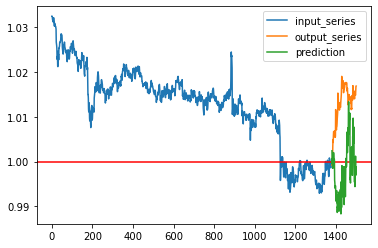

In [31]:
idx = 300
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# pred_dim1 = np.zeros(120)
# pred_dim1 = preds[0,,0]
# pred_dim1.shape

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), test_pred_array[idx], label = 'prediction')
plt.legend()
plt.show()

제대로 학습되지 않고 있다는 것을 알 수 있다.

In [32]:
submission.to_csv('submission1.csv', index = False)